# **Libraries.**


In [49]:
'''
    Import related libraries'''
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import scipy.constants as const
import scipy.special
from scipy.optimize import curve_fit
from scipy.integrate import quad, dblquad

from PIL import Image

from google.colab import files
from IPython.display import Markdown, display
import matplotlib.ticker as mticker
from matplotlib.ticker import MaxNLocator, AutoMinorLocator, LinearLocator, FuncFormatter, LogLocator
import matplotlib.dates as mdates

from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import export_graphviz
import graphviz
from google.colab import files
from sklearn import tree
from sklearn.inspection import partial_dependence
#from treeinterpreter import treeinterpreter as ti



# **Import files.**


In [50]:
'''
   Upload and read files'''
uploaded = files.upload(); # Upload command.
choosefiles = list(uploaded.keys()); # Choose files.

'''
   Store and read data frames'''
# Empty lists to store dataframes and file names//
dfs = []; # To store dataframes from uploaded files.
file_names = []; # To store file names.

# Load all uploaded files and their data//
for file_name in choosefiles:
    xls = pd.ExcelFile(file_name); # Open Excel file and inspect its contents.
    df = pd.read_excel(file_name, sheet_name=xls.sheet_names[0]); # Read sheet into a pandas dataframe.
    dfs.append(df); # Store the dataframe.
    file_names.append(file_name); # Store the file names.

    # Print the first few rows of each file//
    print(f"First few lines of {file_name}:");
    print(df.head()); # Display the first 5 rows of the dataframe.
    print("\n" + "="*50 + "\n"); # Separator for clarity.


Saving x = 0 mm.xlsx to x = 0 mm (2).xlsx
Saving x = 7.79475 mm.xlsx to x = 7.79475 mm (2).xlsx
Saving x = 12.86946 mm.xlsx to x = 12.86946 mm (2).xlsx
Saving x = 17.90498 mm.xlsx to x = 17.90498 mm (2).xlsx
Saving x = 23.07683 mm.xlsx to x = 23.07683 mm (2).xlsx
Saving x = 27.48345 mm.xlsx to x = 27.48345 mm (2).xlsx
Saving x = 32.9586 mm.xlsx to x = 32.9586 mm (2).xlsx
Saving x = 37.681 mm.xlsx to x = 37.681 mm (2).xlsx
Saving x = 42.79084 mm.xlsx to x = 42.79084 mm (2).xlsx
Saving x = 47.84624 mm.xlsx to x = 47.84624 mm (2).xlsx
Saving x = 52.68388 mm.xlsx to x = 52.68388 mm (2).xlsx
Saving x = 57.00472 mm.xlsx to x = 57.00472 mm (2).xlsx
First few lines of x = 0 mm (2).xlsx:
                     Unnamed: 0        Unnamed: 1  Unnamed: 2  Unnamed: 3  \
0  Temperatures, d = 0.00000 mm               NaN         NaN         NaN   
1                           NaN  T (K) at t (min)         NaN         NaN   
2                         P (W)                 1    2.000000    3.000000   
3   

# **Process data files.**


In [51]:
'''
   Process and arrange data'''
def process_file(file_path, x_value):
    # Load the file//
    df = pd.read_excel(file_path, skiprows=2); # Skip metadata rows.
    df.columns = df.iloc[0]; # Set the first row as column headers.
    df = df[1:]; # Drop the first row.

    # Clean up the dataframe//
    df = df.rename(columns={df.columns[0]: 'P (W)'}).reset_index(drop=True);
    df = df.dropna(axis=1, how='all'); # Remove entirely empty columns.
    df = df.dropna(axis=0, how='all'); # Remove entirely empty rows.

    # Melt the dataframe to long format//
    df_melted = df.melt(id_vars=['P (W)'], var_name='t (min)', value_name='Temperature (K)');
    df_melted['x (mm)'] = x_value; # Add the x value to the dataframe.
    return df_melted

'''
   Combining data from multiple files'''
# Arrange files based on the x_positions//
x_positions = [0, 7.79475, 12.86946, 17.90498, 23.07683, 27.48345, 32.9586,
               37.681, 42.79084, 47.84624, 52.68388, 57.00472];

# Process all files and combine into one dataset//
processed_dataframes = [];
for file, x in zip(file_names, x_positions): # Combines each file path with the corresponding x-position.
    processed_df = process_file(file, x); # Process the data for each file.
    processed_dataframes.append(processed_df); # Processed data for each file is appended to the list.

# Combine all processed dataframes//
combined_data = pd.concat(processed_dataframes, ignore_index=True); # Concatenates all the processed dataframmes into a single dataframe.

# Rearrange columns to show in the order of x, P, t, T//
rearrange_combined_data = combined_data[['x (mm)', 'P (W)', 't (min)', 'Temperature (K)']];

# Print the processed data in sequence of (x, P, t, T)//
print("Processed Temperature Data in Sequence (x, P, t, T):");
print(rearrange_combined_data);


Processed Temperature Data in Sequence (x, P, t, T):
        x (mm)  P (W) t (min)  Temperature (K)
0      0.00000    0.1     1.0       294.436555
1      0.00000    0.6     1.0       300.853524
2      0.00000    1.5     1.0       312.365388
3      0.00000    2.4     1.0       323.833002
4      0.00000      4     1.0       344.113860
...        ...    ...     ...              ...
3055  57.00472  20.16    15.0       300.632005
3056  57.00472  21.66    15.0       301.427982
3057  57.00472   23.2    15.0       302.266051
3058  57.00472   23.6    15.0       302.487068
3059  57.00472     24    15.0       302.710251

[3060 rows x 4 columns]


# **Random forest.**


In [52]:
''' Preparing data for model'''
# Prepare data for Random Forest//
X = combined_data[['x (mm)', 'P (W)', 't (min)']].astype(float); # Features.
y = combined_data['Temperature (K)'].astype(float); # Target.

# Split data into training and testing sets//
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42); # Test_size means data for testing.
temperature_points = len(y_test); print(f"Number of Temperature Points Used in Plot: {temperature_points}");

# Train Random Forest model//
#rf_model = RandomForestRegressor(n_estimators=100, random_state=42);


Number of Temperature Points Used in Plot: 612


# **Plot.**


In [54]:
''' Evaluating different number of estimators (trees in the forest) '''

results = [];

# Loop through different numbers of estimators//
for n_estimators in range(10, 101, 10):
    rf_model = RandomForestRegressor(n_estimators=n_estimators, random_state=42)
    rf_model.fit(X_train, y_train)
    y_pred = rf_model.predict(X_test)
    mse = mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    results.append({
        'n_estimators': n_estimators,
        'mse': mse,
        'r2': r2,
        'model': rf_model
    })


# Find the best model
best_result = min(results, key=lambda x: x['mse'])
best_model = best_result['model']
best_n_estimators = best_result['n_estimators']
best_mse = best_result['mse']
best_r2 = best_result['r2']

print(f"Best model (lowest MSE):")
print(f"Number of estimators: {best_n_estimators}")
print(f"Mean Squared Error: {best_mse}")
print(f"R² Score: {best_r2}")

# Use the best model for predictions
y_pred_best = best_model.predict(X_test)
r2_best = r2_score(y_test, y_pred_best)

# Extract data for plotting
n_estimators = [result['n_estimators'] for result in results];
mse_values = [result['mse'] for result in results];
r2_values = [result['r2'] for result in results];



Best model (lowest MSE):
Number of estimators: 80
Mean Squared Error: 3.4085696057478074
R² Score: 0.9995840822067054


<ipython-input-55-96a2b0738c4b>:36: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout();


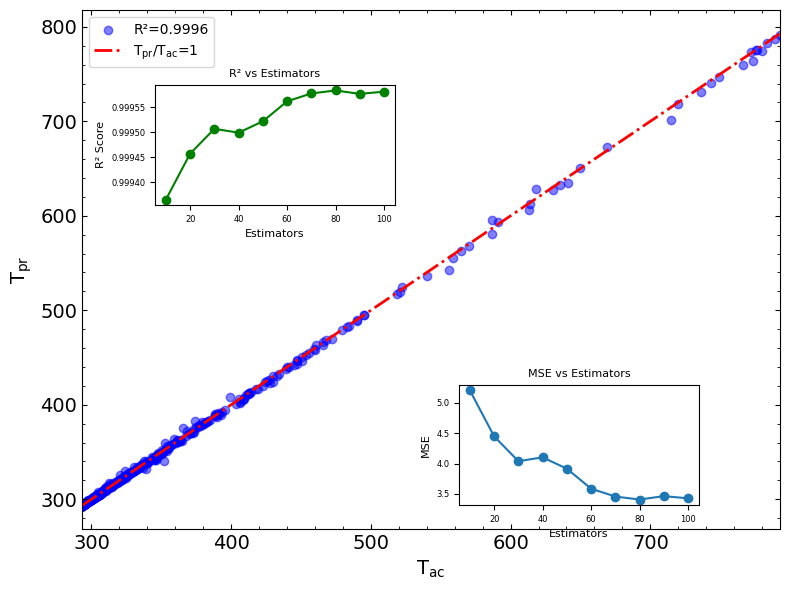

In [55]:
''' Plotting the results'''

fig, ax_main = plt.subplots(figsize=(8, 6));

# Main scatter plot//
ax_main.scatter(y_test, y_pred_best, alpha=0.5, marker='o', color='blue', label=f'R²={r2_best:.4f}')
ax_main.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r-.', lw=2, label='T$_{\mathrm{pr}}$/T$_{\mathrm{ac}}$=1')

# Main plot settings//
ax_main.set_xlabel(r'T$_{\mathrm{ac}}$', alpha=1, fontsize=14);
ax_main.set_ylabel(r'T$_{\mathrm{pr}}$', alpha=1, fontsize=14);
ax_main.set_xlim(np.min(y_test), np.max(y_test));
ax_main.tick_params(which="both", axis="x", direction="in", bottom=True, top=True, labelsize=14);
ax_main.tick_params(which="both", axis="y", direction="in", left=True, right=True, labelsize=14);
ax_main.xaxis.set_minor_locator(AutoMinorLocator());
ax_main.yaxis.set_minor_locator(AutoMinorLocator());
ax_main.legend(loc='upper left', fontsize=10);

# Create inset axes for MSE plot//
ax_inset1 = fig.add_axes([0.58, 0.15, 0.3, 0.2]);
ax_inset1.plot(n_estimators, mse_values, marker='o');
ax_inset1.set_xlabel('Estimators', fontsize=8);
ax_inset1.set_ylabel('MSE', fontsize=8);
ax_inset1.tick_params(axis='both', which='major', labelsize=6);
ax_inset1.set_title('MSE vs Estimators', fontsize=8);

# Create inset axes for R² plot//
#ax_inset2 = fig.add_axes([0.58, 0.45, 0.3, 0.2]);
ax_inset2 = fig.add_axes([0.2, 0.65, 0.3, 0.2]);
ax_inset2.plot(n_estimators, r2_values, marker='o', color='green');
ax_inset2.set_xlabel('Estimators', fontsize=8);
ax_inset2.set_ylabel('R² Score', fontsize=8);
ax_inset2.tick_params(axis='both', which='major', labelsize=6);
ax_inset2.set_title('R² vs Estimators', fontsize=8);

plt.tight_layout();
plt.show();


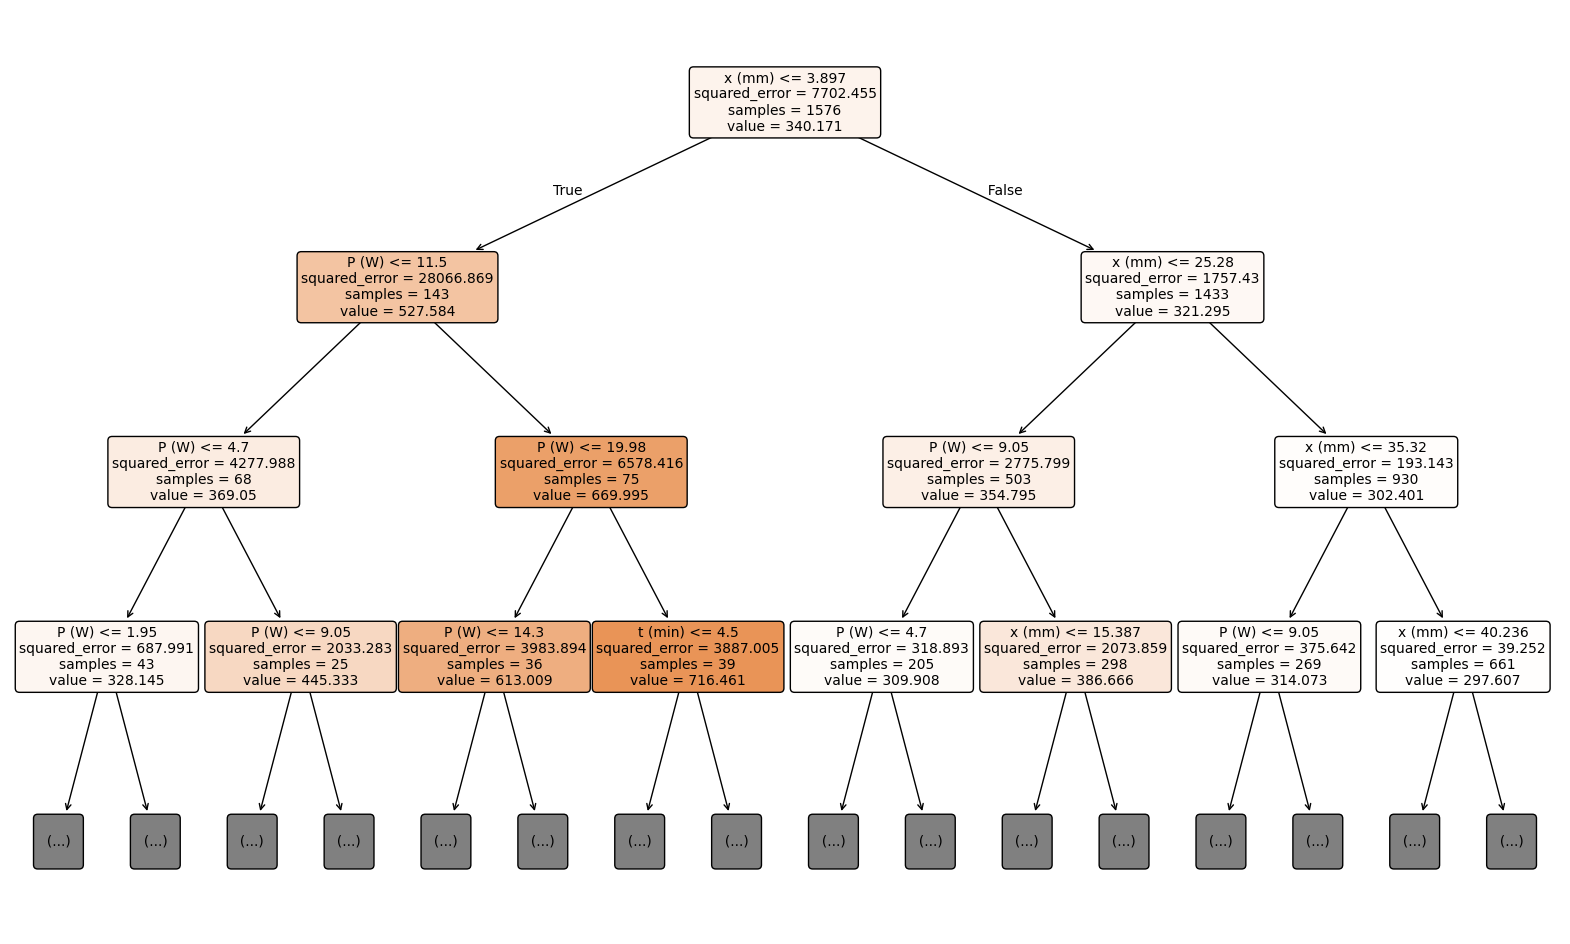

Maximum tree depth of first tree: 18


In [56]:
''' Visualizing the firdt tree in the forest only upto depth=3'''
# Choose the tree to visualize
tree_to_visualize = best_model.estimators_[0];

plt.figure(figsize=(20, 12)); # Adjust figure size as needed
tree.plot_tree(tree_to_visualize,
                    max_depth=3,
                    feature_names=['x (mm)', 'P (W)', 't (min)'],
                    filled=True,rounded=True, fontsize=10);
plt.show();

first_tree_max_depth = tree_to_visualize.tree_.max_depth;
print(f"Maximum tree depth of first tree: {first_tree_max_depth}");
#plt.savefig("decision_tree_snippet.png", dpi=300);

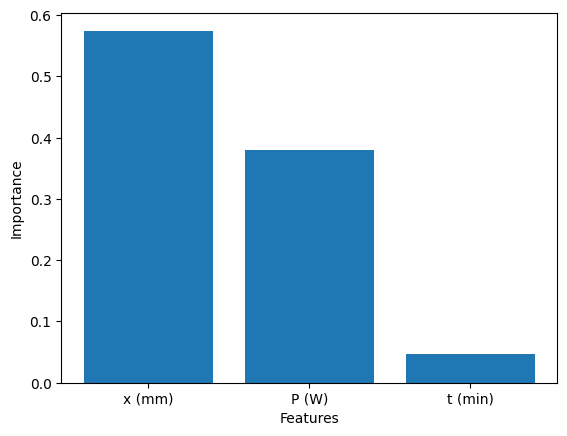

In [57]:
feature_importances = rf_model.feature_importances_;
feature_names = ['x (mm)', 'P (W)', 't (min)'];

# Create a bar plot of feature importances//
plt.bar(feature_names, feature_importances);
plt.xlabel('Features');
plt.ylabel('Importance');
plt.show();